First few rows of the dataset:
         Date  Close/Last    Volume    Open    High     Low
0  07/26/2024      2381.0  149096.0  2363.8  2389.7  2354.6
1  07/25/2024      2353.5  283181.0  2398.1  2400.8  2351.9
2  07/24/2024      2415.7  240326.0  2410.7  2433.0  2397.0
3  07/23/2024      2407.3  168046.0  2398.0  2413.5  2389.2
4  07/22/2024      2394.7  194208.0  2403.7  2414.4  2385.2

Dataset shape: (2530, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2530 non-null   object 
 1   Close/Last  2530 non-null   float64
 2   Volume      2512 non-null   float64
 3   Open        2530 non-null   float64
 4   High        2530 non-null   float64
 5   Low         2530 non-null   float64
dtypes: float64(5), object(1)
memory usage: 118.7+ KB
None

Dataset description:
        Close/Last         Volume         Open       

Training data size: 2387
Test data size: 143


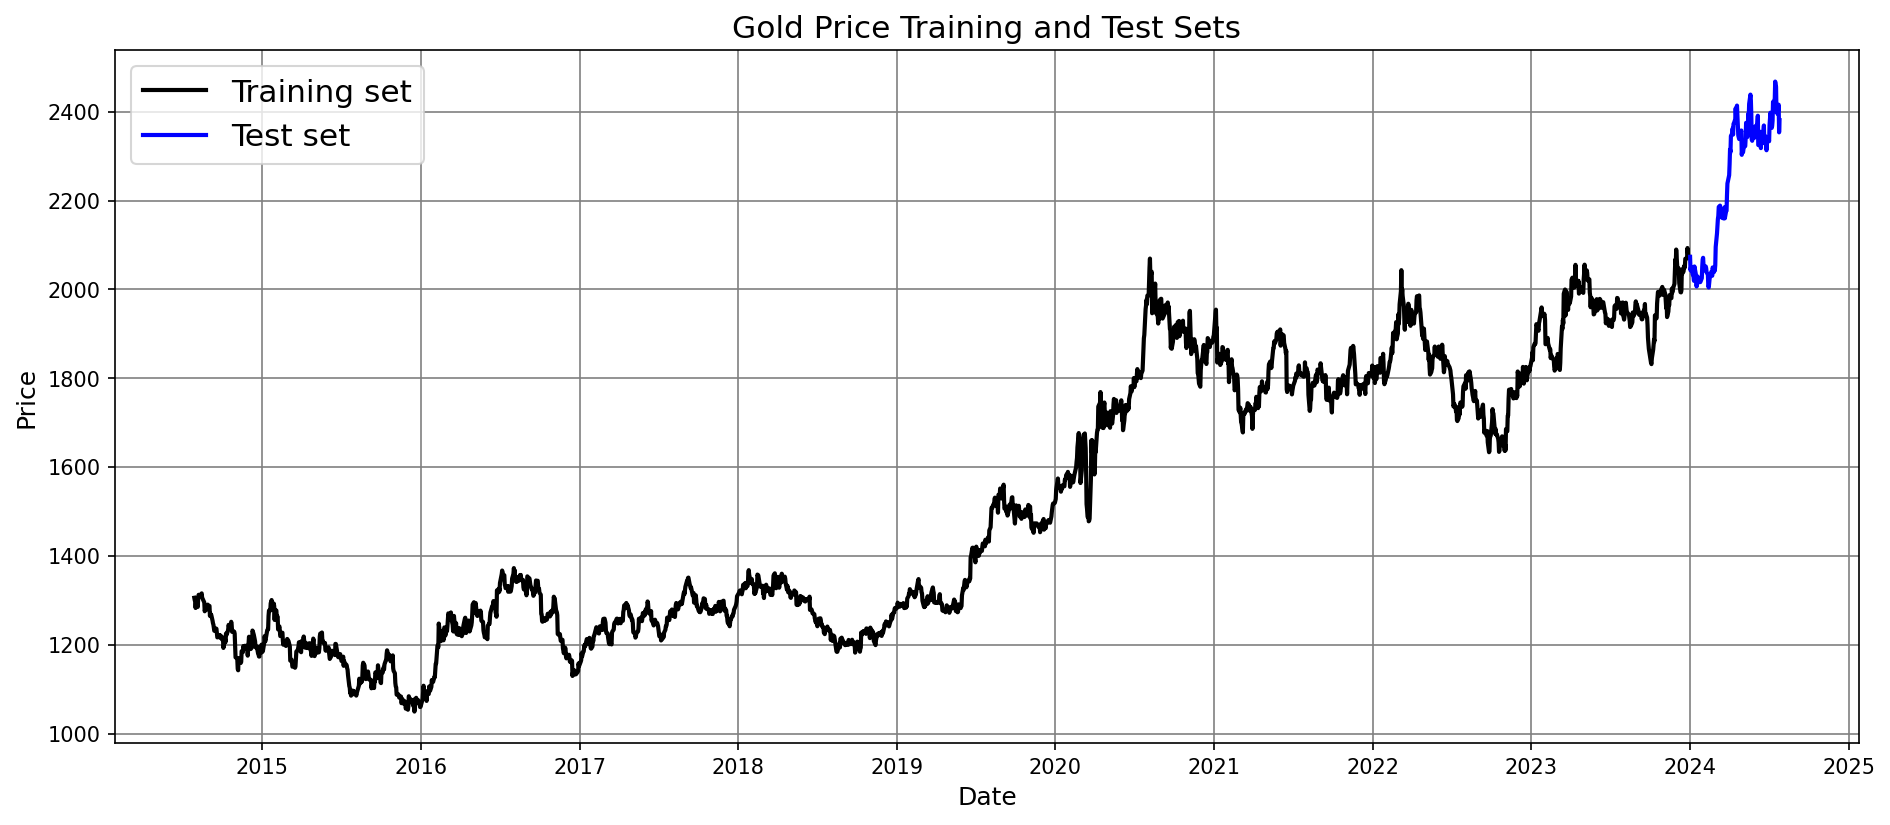

X_train Shape: (2327, 60, 1)
y_train Shape: (2327,)
X_test Shape: (143, 60, 1)
y_test Shape: (143,)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_12 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_13 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                         

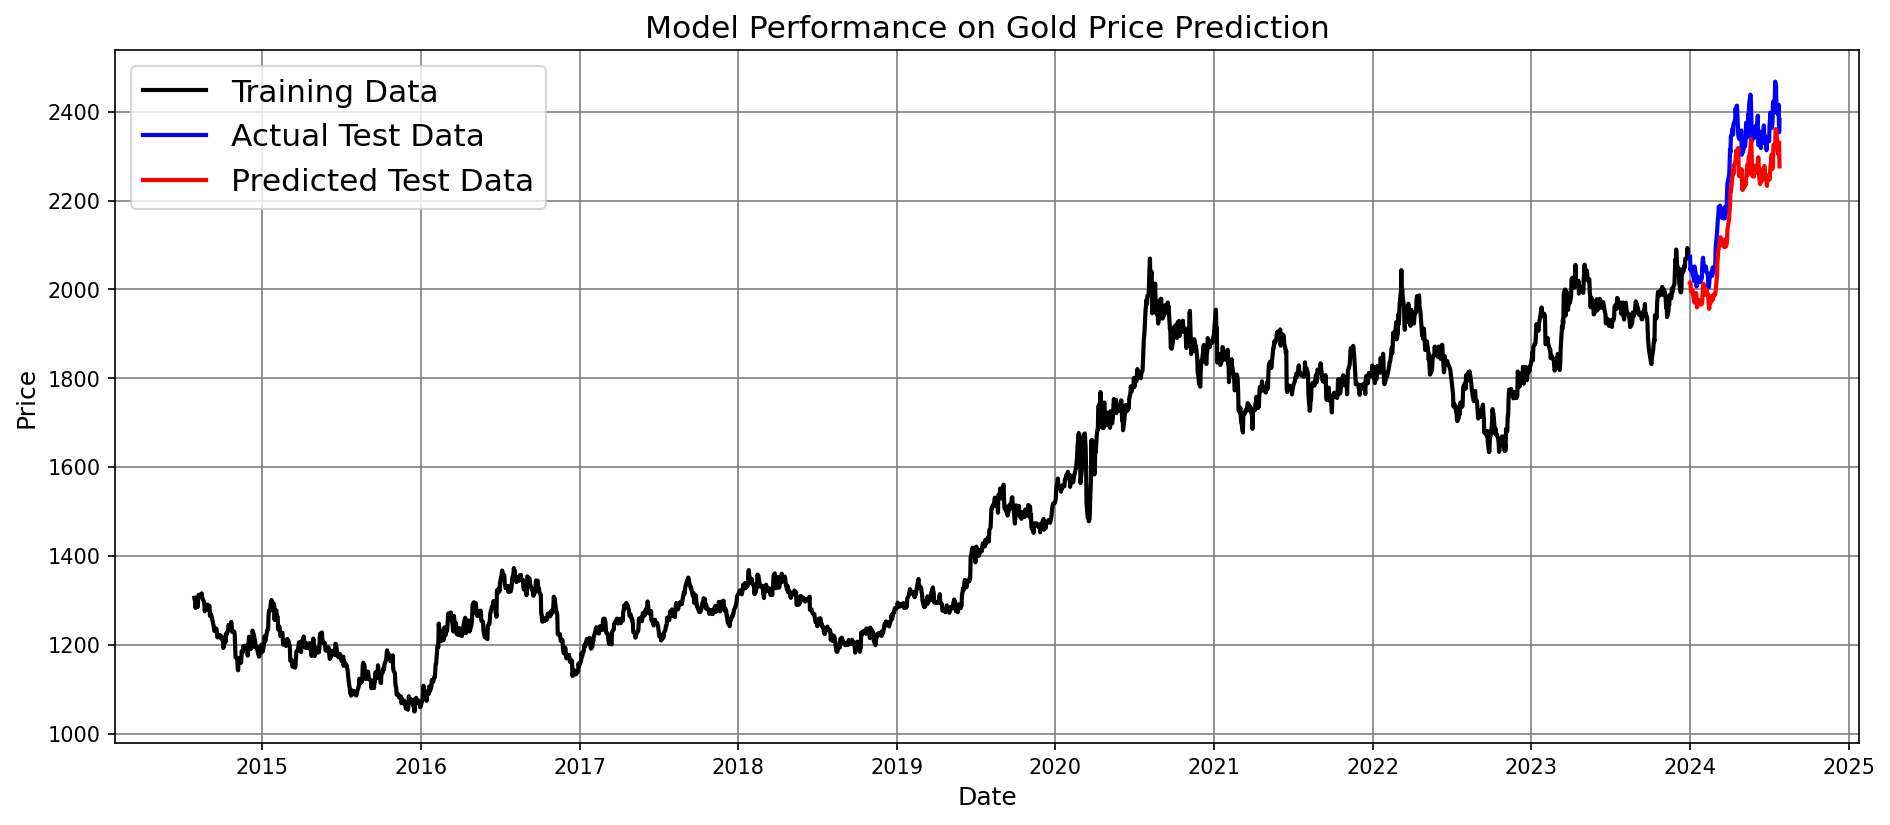

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
import warnings
warnings.filterwarnings('ignore')


# Load the dataset
df = pd.read_csv('Gold Price History.csv')

# Basic data exploration
print("First few rows of the dataset:")
print(df.head())

print("\nDataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nDataset description:")
print(df.describe())

# Feature selection: Drop 'Volume' column and rename 'Close/Last' to 'Price'
df.drop(['Volume'], axis=1, inplace=True)

df.rename(columns={'Close/Last': 'Price'}, inplace=True)

# Convert date column and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)


# Data scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

# Remove redundant symbols and convert to float
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

# Check for duplicates and missing values
print("\nNumber of duplicate rows:", df.duplicated().sum())
print("Number of missing values:", df.isnull().sum().sum())

# Visualize historical gold prices
fig = px.line(df, x='Date', y='Price', title='Gold Price History Data', labels={'Price': 'Scaled Price'})
fig.update_traces(line_color='black')
fig.show()

test_size = df[df.Date.dt.year>=2024].shape[0]
test_size

# Filter data for training and testing
train_data = df[df.Date.dt.year < 2024]
test_data = df[df.Date.dt.year == 2024]

# Print the sizes of the splits
print(f"Training data size: {train_data.shape[0]}")
print(f"Test data size: {test_data.shape[0]}")

# Plot training and test sets
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes', edgecolor='black', facecolor='white')
plt.rc('figure', facecolor='white')

plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2, label='Training set')
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2, label='Test set')
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='gray')  # Adjust grid color as needed
plt.show()

# Define window size
window_size = 60

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training set
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))
X_train, y_train = create_dataset(train_data, window_size)

# Create test set
test_data = df.Price[-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test, y_test = create_dataset(test_data, window_size)

# Reshape data to fit LSTM input requirements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


# Define the model
def define_model(window_size):
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model



# Train the model
model = define_model(window_size)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

# Transform prices back to original scale
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes', edgecolor='black', facecolor='white')
plt.rc('figure', facecolor='white')

plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2, label='Training Data')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Actual Test Data')
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Predicted Test Data')

plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='gray')  # Adjust grid color as needed
plt.show()

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
import warnings
warnings.filterwarnings('ignore')

# Data scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

MinMaxScaler()

In [20]:

# Load the dataset
df = pd.read_csv('Gold Price History.csv')

# Basic data exploration
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
         Date  Close/Last    Volume    Open    High     Low
0  07/26/2024      2381.0  149096.0  2363.8  2389.7  2354.6
1  07/25/2024      2353.5  283181.0  2398.1  2400.8  2351.9
2  07/24/2024      2415.7  240326.0  2410.7  2433.0  2397.0
3  07/23/2024      2407.3  168046.0  2398.0  2413.5  2389.2
4  07/22/2024      2394.7  194208.0  2403.7  2414.4  2385.2


In [21]:
print("\nDataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nDataset description:")
print(df.describe())


Dataset shape: (2530, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2530 non-null   object 
 1   Close/Last  2530 non-null   float64
 2   Volume      2512 non-null   float64
 3   Open        2530 non-null   float64
 4   High        2530 non-null   float64
 5   Low         2530 non-null   float64
dtypes: float64(5), object(1)
memory usage: 118.7+ KB
None

Dataset description:
        Close/Last         Volume         Open         High          Low
count  2530.000000    2512.000000  2530.000000  2530.000000  2530.000000
mean   1546.226759  190975.568073  1546.167510  1556.274545  1536.021542
std     340.044045   96567.142473   340.105851   342.906206   337.100561
min    1049.600000       1.000000  1051.500000  1062.700000  1045.400000
25%    1249.775000  134496.500000  1249.500000  1256.875000  1242.450000
50%   

In [22]:
# Feature selection: Drop 'Volume' column and rename 'Close/Last' to 'Price'
df.drop(['Volume'], axis=1, inplace=True)

In [23]:
df.rename(columns={'Close/Last': 'Price'}, inplace=True)

In [24]:
# Convert date column and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [25]:


# Remove redundant symbols and convert to float
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

# Check for duplicates and missing values
print("\nNumber of duplicate rows:", df.duplicated().sum())
print("Number of missing values:", df.isnull().sum().sum())



Number of duplicate rows: 0
Number of missing values: 0


In [26]:
# Visualize historical gold prices
fig = px.line(df, x='Date', y='Price', title='Gold Price History Data', labels={'Price': 'Scaled Price'})
fig.update_traces(line_color='black')
fig.show()


In [27]:

# Data scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

MinMaxScaler()

In [28]:
test_size = df[df.Date.dt.year>=2024].shape[0]
test_size

# Filter data for training and testing
train_data = df[df.Date.dt.year < 2024]
test_data = df[df.Date.dt.year == 2024]

# Print the sizes of the splits
print(f"Training data size: {train_data.shape[0]}")
print(f"Test data size: {test_data.shape[0]}")

Training data size: 2387
Test data size: 143


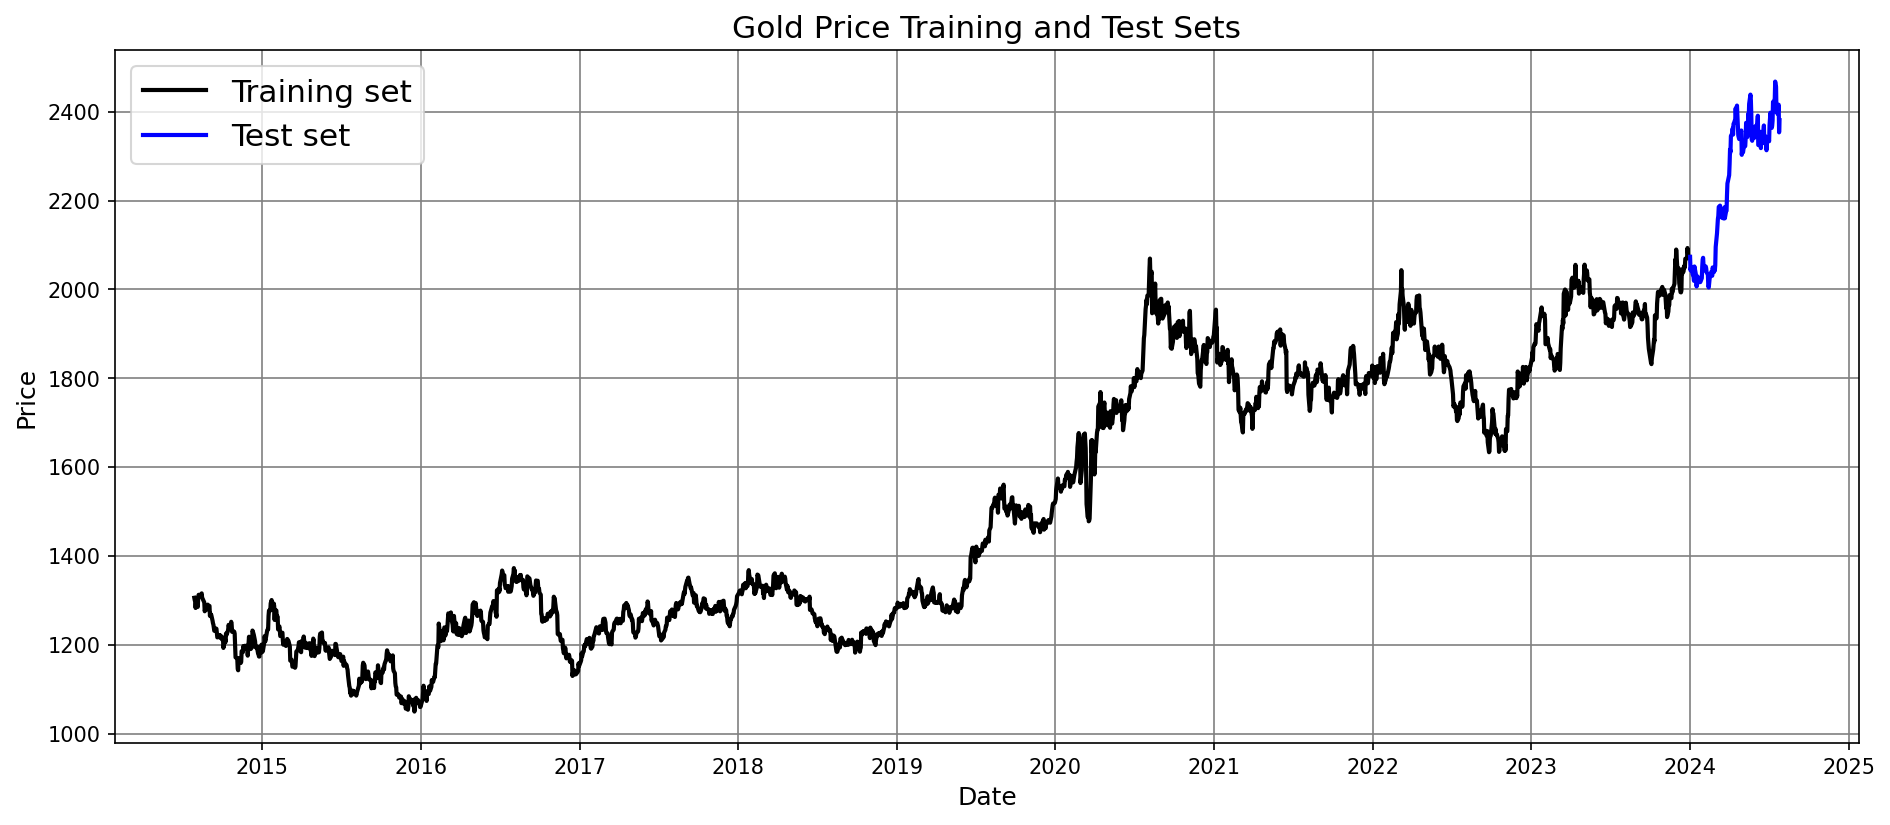

In [29]:
# Plot training and test sets
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes', edgecolor='black', facecolor='white')
plt.rc('figure', facecolor='white')

plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2, label='Training set')
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2, label='Test set')
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='gray')  # Adjust grid color as needed
plt.show()

In [30]:
# Data scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

MinMaxScaler()

In [31]:

# Define window size
window_size = 60

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training set
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))
X_train, y_train = create_dataset(train_data, window_size)

# Create test set
test_data = df.Price[-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test, y_test = create_dataset(test_data, window_size)

# Reshape data to fit LSTM input requirements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (2327, 60, 1)
y_train Shape: (2327,)
X_test Shape: (143, 60, 1)
y_test Shape: (143,)


In [32]:

# Define the model
def define_model(window_size):
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model



In [33]:

# Train the model
model = define_model(window_size)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

1/5 [=====>........................] - ETA: 0s - loss: 0.0018

5/5 [==============================] - 1s 14ms/step
Test Loss: 0.007674390450119972
Test MAPE: 0.09480223670148517
Test Accuracy: 0.9051977632985149


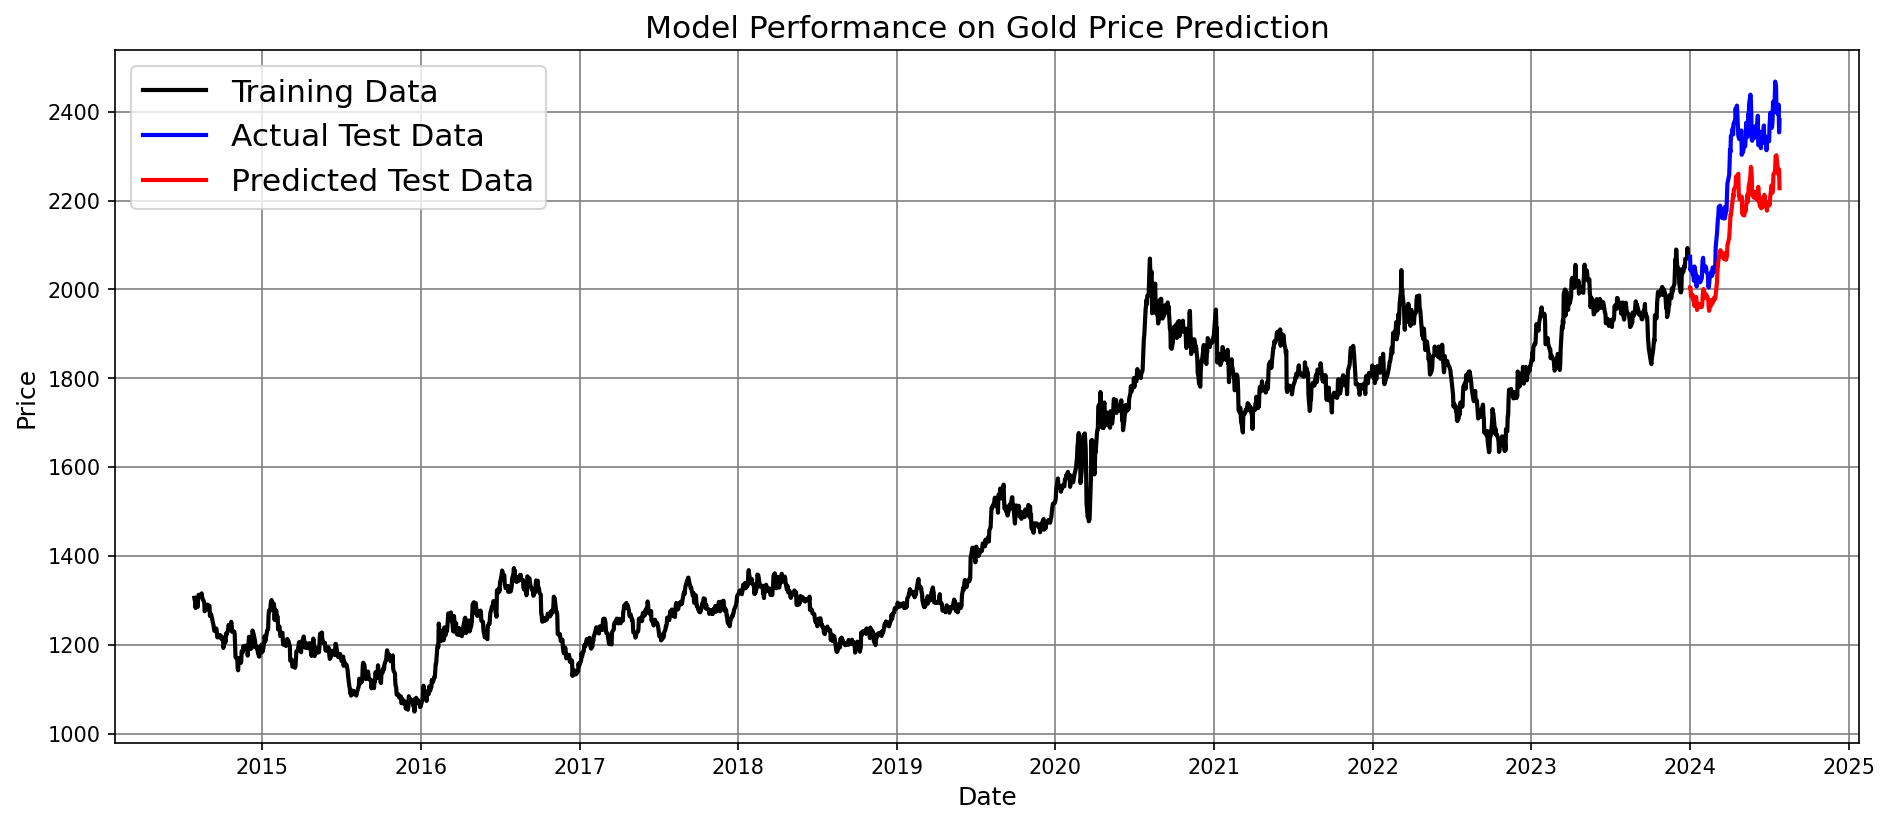

In [34]:
# Evaluate the model
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

# Transform prices back to original scale
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes', edgecolor='black', facecolor='white')
plt.rc('figure', facecolor='white')

plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2, label='Training Data')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Actual Test Data')
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Predicted Test Data')

plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='gray')  # Adjust grid color as needed
plt.show()

 # Improvement


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Gold Price History.csv')

# Data preprocessing
df.drop(['Volume'], axis=1, inplace=True)
df.rename(columns={'Close/Last': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove redundant symbols and convert to float
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

# Check for duplicates and missing values
print("\nNumber of duplicate rows:", df.duplicated().sum())
print("Number of missing values:", df.isnull().sum().sum())

# Add moving averages
df['MA_10'] = df['Price'].rolling(window=10).mean()
df['MA_30'] = df['Price'].rolling(window=30).mean()
df.fillna(method='bfill', inplace=True)

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price', 'MA_10', 'MA_30']])

# Define window size
window_size = 60

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Split the data into training and test sets
test_size = df[df.Date.dt.year == 2022].shape[0]
train_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size-window_size:]

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Define the model
def define_model(window_size, num_features):
    input1 = Input(shape=(window_size, num_features))
    x = Bidirectional(LSTM(units=64, return_sequences=True))(input1)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(units=64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(units=64))(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

# Train the model
model = define_model(window_size, X_train.shape[2])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - mape

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")
print(f"Test Accuracy: {accuracy}")

# Predict future prices for the next 300 days
future_steps = 300  # Number of days to predict

# Start with the last window of the test data
last_window = test_data[-window_size:]

future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_window[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    
    # Update the window to include the new prediction
    new_entry = np.array([prediction, prediction, prediction]).reshape(1, -1)
    last_window = np.concatenate([last_window[1:], new_entry], axis=0)

# Create a dummy dataset for inverse transformation
dummy_future_data = np.zeros((future_steps, scaled_data.shape[1]))
dummy_future_data[:, 0] = future_predictions

# Transform predictions back to original scale
future_predictions_scaled = scaler.inverse_transform(dummy_future_data)[:, 0]

# Extend the dataframe with future dates and predicted prices
last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions_scaled.flatten()})




Number of duplicate rows: 0
Number of missing values: 0
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 3)]           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 60, 128)           34816     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 60, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 60, 128)           74496     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 60, 128)           0         
                                                                 
 b

KeyboardInterrupt: 

ValueError: non-broadcastable output operand with shape (311,1) doesn't match the broadcast shape (311,3)

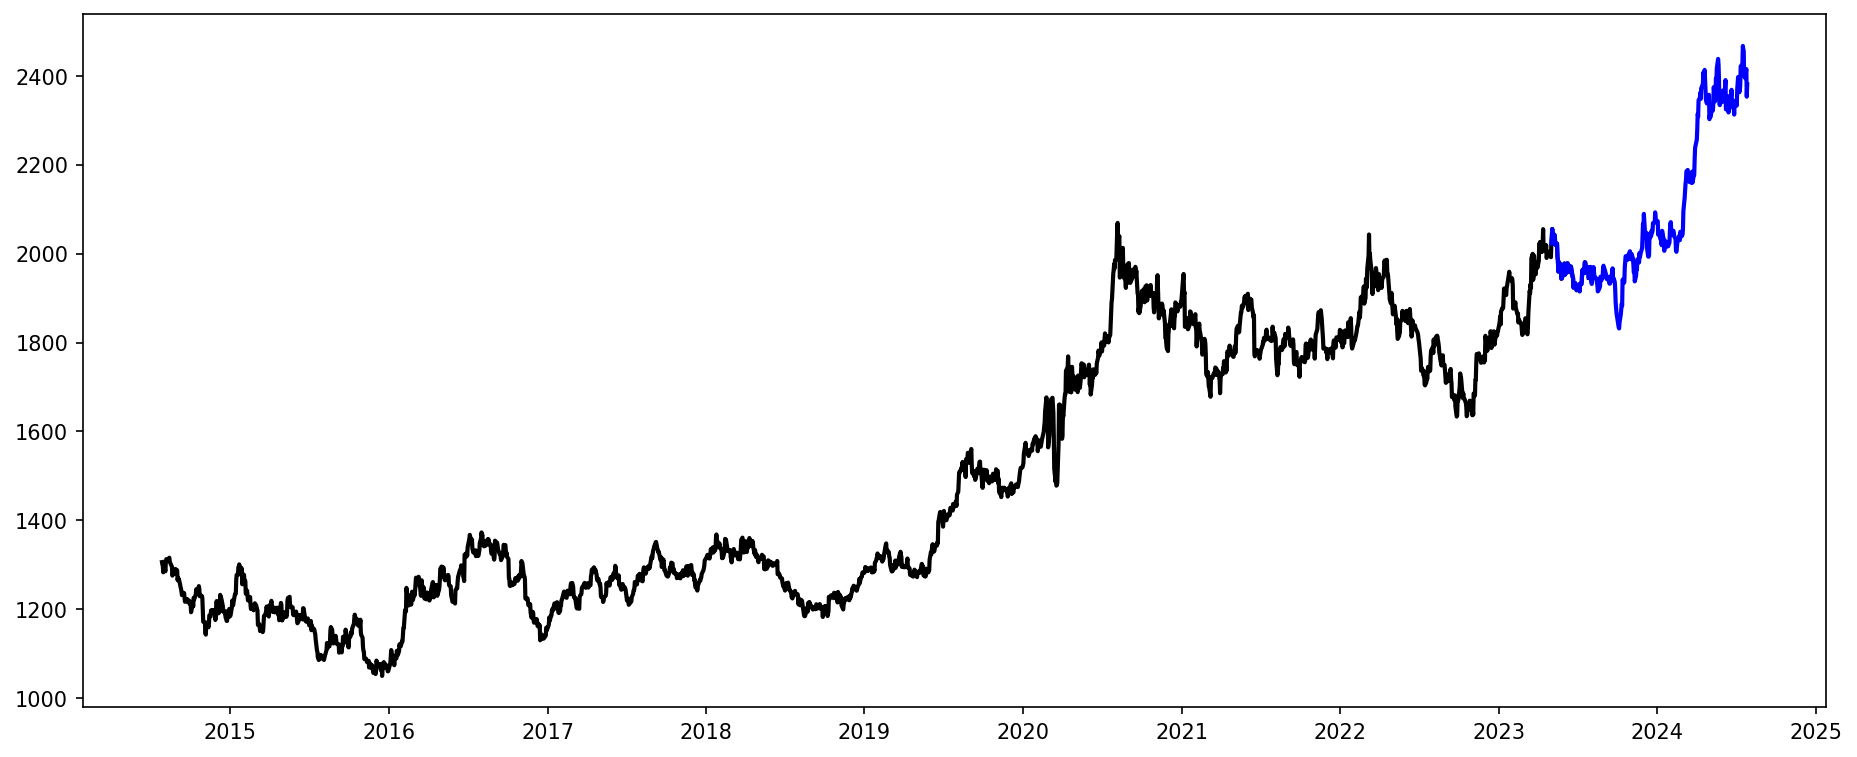

In [ ]:
y_pred_expanded = np.repeat(y_pred, 3, axis=1)
# Plot the results
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data)[:, 0], color='black', lw=2, label='Training Data')
plt.plot(df['Date'].iloc[-(test_size+window_size):], scaler.inverse_transform(test_data)[:, 0], color='blue', lw=2, label='Actual Test Data')
plt.plot(df['Date'].iloc[-test_size:], scaler.inverse_transform(np.concatenate([train_data[-window_size:, :1], y_pred], axis=0))[:, 0], color='red', lw=2, label='Predicted Test Data')
plt.plot(future_df['Date'], future_df['Predicted Price'], color='green', lw=2, label='Future Predictions')
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid()
plt.show()

In [ ]:
# Inspect y_pred
print("Shape of y_pred:", y_pred.shape)
print("\nFirst few elements of y_pred:")
print(y_pred[:5])  # Print the first 5 elements

# Inspect train_data
print("\nShape of train_data:", train_data.shape)
print("\nFirst few rows of train_data:")
print(train_data[:5])  # Print the first 5 rows

Shape of y_pred: (250, 1)

First few elements of y_pred:
[[0.6442525 ]
 [0.64626163]
 [0.6432486 ]
 [0.6399684 ]
 [0.63643366]]

Shape of train_data: (2280, 3)

First few rows of train_data:
[[0.18065153 0.17119294 0.17120527]
 [0.1769144  0.17119294 0.17120527]
 [0.17437597 0.17119294 0.17120527]
 [0.16443379 0.17119294 0.17120527]
 [0.17289522 0.17119294 0.17120527]]


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# Fetch historical gold price data from Yahoo Finance
gold_data = yf.download('GC=F', start='2010-01-01', end='2023-12-31')

# Reset the index to get 'Date' as a column
gold_data.reset_index(inplace=True)

# Rename columns to match your existing dataset
gold_data = gold_data.rename(columns={'Close': 'Price'})

# Keep only the necessary columns
gold_data = gold_data[['Date', 'Price']]

# Load your existing dataset
# df = pd.read_csv('Gold Price History.csv')

# Combine the datasets (assuming df contains older data)
# df = pd.concat([df, gold_data]).drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)

# For demonstration, we'll use gold_data directly
df = gold_data.copy()

# Data preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Add moving averages
df['MA_10'] = df['Price'].rolling(window=10).mean()
df['MA_30'] = df['Price'].rolling(window=30).mean()
df.fillna(method='bfill', inplace=True)

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price', 'MA_10', 'MA_30']])

# Define window size
window_size = 60

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Split the data into training and test sets
test_size = df[df.Date.dt.year == 2022].shape[0]
train_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size-window_size:]

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Define the model
def define_model(window_size, num_features):
    input1 = Input(shape=(window_size, num_features))
    x = Bidirectional(LSTM(units=64, return_sequences=True))(input1)
    x = Dropout(0.2)(x)
    x = Bidirectional(GRU(units=64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(units=64))(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

# Train the model
model = define_model(window_size, X_train.shape[2])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])



[*********************100%%**********************]  1 of 1 completed

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 3)]           0         
                                                                 
 bidirectional (Bidirection  (None, 60, 128)           34816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 60, 128)           74496     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816 

In [ ]:

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - mape

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")
print(f"Test Accuracy: {accuracy}")

# Predict future prices for the next 300 days
future_steps = 300  # Number of days to predict

# Start with the last window of the test data
last_window = test_data[-window_size:]

future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_window[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    
    # Update the window to include the new prediction
    new_entry = np.array([prediction, prediction, prediction]).reshape(1, -1)
    last_window = np.concatenate([last_window[1:], new_entry], axis=0)

# Create a dummy dataset for inverse transformation
dummy_future_data = np.zeros((future_steps, scaled_data.shape[1]))
dummy_future_data[:, 0] = future_predictions

# Transform predictions back to original scale
future_predictions_scaled = scaler.inverse_transform(dummy_future_data)[:, 0]

# Extend the dataframe with future dates and predicted prices
last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions_scaled.flatten()})

# Plot the results
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data)[:, 0], color='black', lw=2, label='Training Data')
plt.plot(df['Date'].iloc[-test_size:], scaler.inverse_transform(test_data)[:, 0], color='blue', lw=2, label='Actual Test Data')
plt.plot(df['Date'].iloc[-test_size:], scaler.inverse_transform(np.concatenate([train_data[-window_size:], y_pred], axis=0))[:, 0], color='red', lw=2, label='Predicted Test Data')
plt.plot(future_df['Date'], future_df['Predicted Price'], color='green', lw=2, label='Future Predictions')
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid()
plt.show()